In [1]:
sc

<SparkContext master=local[3] appName=PySparkShell>

# 2 - DataFrame

A DataFrame is an immutable distributed collection of data that is organized into
named columns analogous to a table in a relational database. 

Spark DataFrame is a similar
concept of <i>Pandas DataFrame</i>, in that it allows users to easily work with structured data (for example, data
tables).

In [2]:
stringJSONRDD = sc.parallelize(("""
     { "id": "123",
    "name": "Katie",
    "age": 19,
    "eyeColor": "brown"
     }""",
    """{
    "id": "234",
    "name": "Michael",
    "age": 22,
    "eyeColor": "green"
     }""",
    """{
    "id": "345",
    "name": "Simone",
    "age": 23,
    "eyeColor": "blue"
     }""")
    )

In [3]:
swimmersJSON = spark.read.json(stringJSONRDD)

In [4]:
swimmersJSON.collect()

[Row(age=19, eyeColor='brown', id='123', name='Katie'),
 Row(age=22, eyeColor='green', id='234', name='Michael'),
 Row(age=23, eyeColor='blue', id='345', name='Simone')]

In [5]:
# Creating a temporary table
swimmersJSON.createOrReplaceTempView('swimmersJSON')

Dataframe API:

In [6]:
swimmersJSON.show()

+---+--------+---+-------+
|age|eyeColor| id|   name|
+---+--------+---+-------+
| 19|   brown|123|  Katie|
| 22|   green|234|Michael|
| 23|    blue|345| Simone|
+---+--------+---+-------+



SQL query:

In [7]:
spark.sql('select * from swimmersJSON').collect()

[Row(age=19, eyeColor='brown', id='123', name='Katie'),
 Row(age=22, eyeColor='green', id='234', name='Michael'),
 Row(age=23, eyeColor='blue', id='345', name='Simone')]

In [8]:
# Print the schema
swimmersJSON.printSchema()

root
 |-- age: long (nullable = true)
 |-- eyeColor: string (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)



Programatically specifying the schema:

In [9]:
# Import data types
from pyspark.sql.types import *

In [10]:
# Generate comma delimited data
stringCSVRDD = sc.parallelize([
    (123, 'Katie', 19, 'brown'),
    (234, 'Michael', 22, 'green'),
    (345, 'Simone', 23, 'blue')
])

In [11]:
# Specify schema
schema = StructType([
    StructField(name = 'id', dataType = LongType(), nullable = True),
    StructField('name', StringType(), True),
    StructField('age', LongType(), True),
    StructField('eyeColor', StringType(), True),
])

Apply the schema to the RDD and Create DataFrame:

In [12]:
swimmers = spark.createDataFrame(stringCSVRDD, schema)

Creates a temporary view using the DataFrame:

In [13]:
swimmers.createOrReplaceTempView('swimmers')

In [14]:
swimmers.printSchema()

root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- age: long (nullable = true)
 |-- eyeColor: string (nullable = true)



## Querying with the DataFrame API:

Count:

In [15]:
swimmers.count()

3

Running filter statements:

In [16]:
# ID and age where age = 22
swimmers.select('*').filter('age == 22').show()

# another way to write the above query is below
# swimmers.select(swimmers.id, swimmers.age)\
#    .filter(swimmers.age == 22).show()

+---+-------+---+--------+
| id|   name|age|eyeColor|
+---+-------+---+--------+
|234|Michael| 22|   green|
+---+-------+---+--------+



In [17]:
# Swimmers who have an eye color that begins with 'b'
swimmers.select('name', 'eyeColor')\
    .filter("eyeColor like 'b%'").show()

+------+--------+
|  name|eyeColor|
+------+--------+
| Katie|   brown|
|Simone|    blue|
+------+--------+



## Querying with SQL

Count:

In [18]:
spark.sql('select count(1) from swimmers').show()

+--------+
|count(1)|
+--------+
|       3|
+--------+



Filter statements with <i>where</i>:

In [19]:
spark.sql('select id,age from swimmers where age = 22').show()

+---+---+
| id|age|
+---+---+
|234| 22|
+---+---+



In [20]:
spark.sql(
"select name,eyeColor from swimmers where eyeColor like 'b%'").show()

+------+--------+
|  name|eyeColor|
+------+--------+
| Katie|   brown|
|Simone|    blue|
+------+--------+



### DataFrame scenario – on-time flight performance

In [21]:
# Set file paths
flightPerfFilePath = "./data/departuredelays.csv"
airportsFilePath = "./data/airport-codes-na.txt"

In [22]:
airports = spark.read.csv(airportsFilePath,
                         header = True,
                         inferSchema = True,
                         sep = '\t')
flightPerf = spark.read.csv(flightPerfFilePath,
                           header = True)

In [23]:
airports.createOrReplaceTempView('airports')
flightPerf.createOrReplaceTempView('flightPerformance')

In [24]:
# Cache the Departure Delays dataset
flightPerf.cache()

DataFrame[date: string, delay: string, distance: string, origin: string, destination: string]

In [25]:
airports.show(5)

+----------+-----+-------+----+
|      City|State|Country|IATA|
+----------+-----+-------+----+
|Abbotsford|   BC| Canada| YXX|
|  Aberdeen|   SD|    USA| ABR|
|   Abilene|   TX|    USA| ABI|
|     Akron|   OH|    USA| CAK|
|   Alamosa|   CO|    USA| ALS|
+----------+-----+-------+----+
only showing top 5 rows



In [26]:
flightPerf.show(5)

+--------+-----+--------+------+-----------+
|    date|delay|distance|origin|destination|
+--------+-----+--------+------+-----------+
|01011245|    6|     602|   ABE|        ATL|
|01020600|   -8|     369|   ABE|        DTW|
|01021245|   -2|     602|   ABE|        ATL|
|01020605|   -4|     602|   ABE|        ATL|
|01031245|   -4|     602|   ABE|        ATL|
+--------+-----+--------+------+-----------+
only showing top 5 rows



Joining flight performance and airports:

In [27]:
# Query Sum of Flight Delays by City and Origin Code
# (for Washington State)

spark.sql("""
select a.City, f.origin, sum(f.delay) as Delays
from flightPerformance f join airports a
on a.IATA = f.origin
where a.State = 'WA'
group by a.City, f.origin
order by sum(f.delay) desc
""").show()

+-------+------+--------+
|   City|origin|  Delays|
+-------+------+--------+
|Seattle|   SEA|159086.0|
|Spokane|   GEG| 12404.0|
|  Pasco|   PSC|   949.0|
+-------+------+--------+



### Visualizing flight-performance data


In [28]:
import matplotlib.pyplot as plt

In [29]:
spark.sql("""
select a.State, sum(f.delay) as Delays
from flightPerformance f join airports a
on a.IATA = f.origin
where a.Country = 'USA'
group by a.State
""").show()

+-----+---------+
|State|   Delays|
+-----+---------+
|   SC|  80666.0|
|   AZ| 401793.0|
|   LA| 199136.0|
|   MN| 256811.0|
|   NJ| 452791.0|
|   OR| 109333.0|
|   VA|  98016.0|
| null| 397237.0|
|   RI|  30760.0|
|   WY|  15365.0|
|   KY|  61156.0|
|   NH|  20474.0|
|   MI| 366486.0|
|   NV| 474208.0|
|   WI| 152311.0|
|   ID|  22932.0|
|   CA|1891919.0|
|   CT|  54662.0|
|   NE|  59376.0|
|   MT|  19271.0|
+-----+---------+
only showing top 20 rows



In [30]:
states_delays_pd = spark.sql("""
select a.State, sum(f.delay) as Delays
from flightPerformance f join airports a
on a.IATA = f.origin
where a.Country = 'USA'
group by a.State
""").toPandas()

In [31]:
states_delays_pd['State'].loc[states_delays_pd['State'].isnull()] = ' '

/home/jvcm/tsenv/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [32]:
states_delays_pd.head()

,State,Delays
0,SC,80666.0
1,AZ,401793.0
2,LA,199136.0
3,MN,256811.0
4,NJ,452791.0


<BarContainer object of 50 artists>

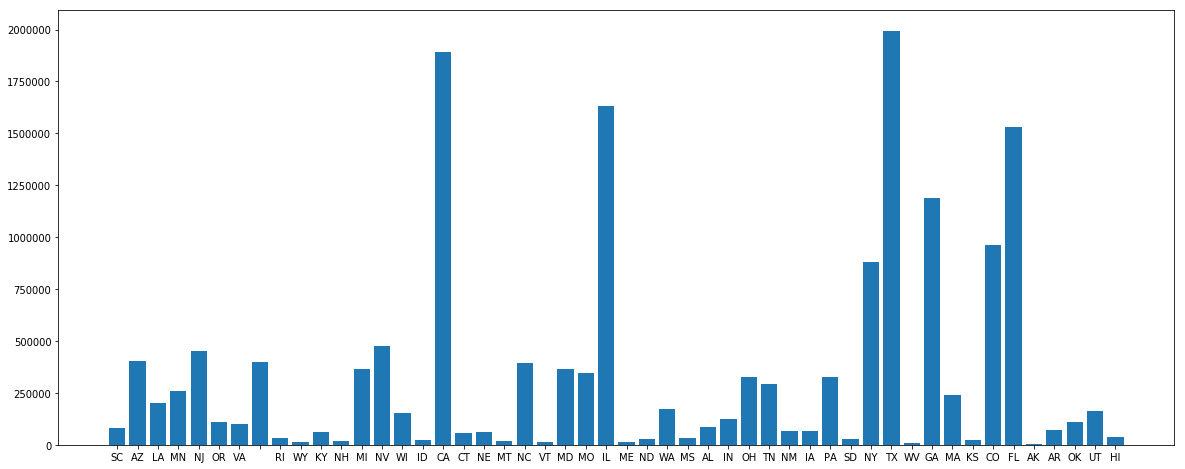

In [33]:
plt.figure(figsize=(20,8))
plt.bar(states_delays_pd['State'], states_delays_pd['Delays'])